## Introduction

In this final project, we'll attempt to predict the type of physical activity (e.g., walking, climbing stairs) from tri-axial smartphone accelerometer data. Smartphone accelerometers are very precise, and different physical activities give rise to different patterns of acceleration.

### Input Data

The input data which we will be using in this project consists of two files.

The first file train_time_series.csv, contains the raw accelerometer data in the following file formats:

Timestamp
UTC time
Accuracy
x, y, z
The second file train_labels.csv contains the activity labels, and we'll be using these label to train our model.

Various activities have been labelled as follows:

1 => Standing
2 => Walking
3 => Climbing down the stairs.
4 => Climbing up the stairs.


#### Goal

Our goal is to classify various physical activities as accurately as possible.

We will test our code against other participants of this course and compare the predictions with the true values of the data with the EdX staff.

##### Script Run-time:

In addition to provide predictions we'll also be runtime of our code.

### Data

Files for dowload:

train_label.csv
train_time_series.csv
test_labels.csv
test_time_series.csv

### Methodology

##### Loading the data

#### Exploratory Data Analysis

Exploration
Data Cleaning
Data Visualisation

#### Feature Engineering

We'll bring in some domain knowledge to define additional features.

#### Build Classification models

Preparation of dataset
Splitting of data
Choosing the right metric
Testing various classifiers:
    Logistic Regression
    K-nearest neighbour
    Random Forest Classification
    Gradient Boosting Classification


#### Validation

We'll use the most successful model to make predictions.

Link for project: https://courses.edx.org/courses/course-v1:HarvardX+PH526x+1T2020/courseware/b7c02161c4804ec0b69818856384ff47/3f9b66504d5c41789b8d58f4f5b02ebe/?child=first

Importing the neccesary packages for computation.

In [1]:
import pandas as pd
import numpy as np
from numpy import savetxt

import matplotlib.pyplot as plt
%matplotlib inline

import requests
import io
from timeit import default_timer

# scikit-learn version 0.22 or greater is required. 
import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

## Loading accelometer data

In [2]:
# Train datasets
X_train_url = requests.get("https://raw.githubusercontent.com/YashKarthik/Python-for-Research-edX-Harvard/master/Final%20Project/train_time_series.csv")
X_train = pd.read_csv(io.StringIO(X_train_url.text), index_col = 0)


y_train_url = requests.get("https://raw.githubusercontent.com/YashKarthik/Python-for-Research-edX-Harvard/master/Final%20Project/train_labels.csv")
y_train = pd.read_csv(io.StringIO(y_train_url.text), index_col = 0)


# Test datasets
X_test_url = requests.get("https://raw.githubusercontent.com/YashKarthik/Python-for-Research-edX-Harvard/master/Final%20Project/test_time_series.csv")
X_test = pd.read_csv(io.StringIO(X_test_url.text), index_col = 0)


y_test_url = requests.get("https://raw.githubusercontent.com/YashKarthik/Python-for-Research-edX-Harvard/master/Final%20Project/test_labels.csv")
y_test = pd.read_csv(io.StringIO(y_test_url.text), index_col = 0)

In [3]:
# Shape check
print("X_train (train_time_series) shape:", X_train.shape)
print("y_train (train_labels) shape:", y_train.shape)
print("X_test (test_time_series) shape:", X_test.shape)
print("y_test (test_labels) shape:", y_test.shape)

X_train (train_time_series) shape: (3744, 6)
y_train (train_labels) shape: (375, 3)
X_test (test_time_series) shape: (1250, 6)
y_test (test_labels) shape: (125, 3)


The shapes of our datasets seem to be consistent.

Note that y-sets (labels) are 1/10 of the X-sets (features), as informed in the project introduction.


In [4]:
print("X_train head: \n%s" % X_train.head(), "\n")
print("y_train head: \n%s" % y_train.head(), "\n")
print("X_test head: \n%s" % X_test.head(), "\n")
print("y_test head: \n%s" % y_test.head(), "\n")

X_train head: 
           timestamp                 UTC time accuracy         x         y  \
20586  1565109930787  2019-08-06T16:45:30.787  unknown -0.006485 -0.934860   
20587  1565109930887  2019-08-06T16:45:30.887  unknown -0.066467 -1.015442   
20588  1565109930987  2019-08-06T16:45:30.987  unknown -0.043488 -1.021255   
20589  1565109931087  2019-08-06T16:45:31.087  unknown -0.053802 -0.987701   
20590  1565109931188  2019-08-06T16:45:31.188  unknown -0.054031 -1.003616   

              z  
20586 -0.069046  
20587  0.089554  
20588  0.178467  
20589  0.068985  
20590  0.126450   

y_train head: 
           timestamp                 UTC time  label
20589  1565109931087  2019-08-06T16:45:31.087      1
20599  1565109932090  2019-08-06T16:45:32.090      1
20609  1565109933092  2019-08-06T16:45:33.092      1
20619  1565109934094  2019-08-06T16:45:34.094      1
20629  1565109935097  2019-08-06T16:45:35.097      1 

X_test head: 
           timestamp                 UTC time accuracy   

## Exploratory Data Analysis.

In [5]:
# Drop "accuracy" column.
for data in [X_train, X_test]:
    data.drop("accuracy", axis = 1, inplace = True)
    
# Drop "UTC time" column.
for data in [X_train, y_train, X_test, y_test]:
    data.drop("UTC time", axis = 1, inplace = True)
    data.reset_index(drop = True, inplace = True)

In [6]:
print("X_train head: \n%s" % X_train.head(), "\n")
print("y_train head: \n%s" % y_train.head(), "\n")
print("X_test head: \n%s" % X_test.head(), "\n")
print("y_test head: \n%s" % y_test.head(), "\n")

X_train head: 
       timestamp         x         y         z
0  1565109930787 -0.006485 -0.934860 -0.069046
1  1565109930887 -0.066467 -1.015442  0.089554
2  1565109930987 -0.043488 -1.021255  0.178467
3  1565109931087 -0.053802 -0.987701  0.068985
4  1565109931188 -0.054031 -1.003616  0.126450 

y_train head: 
       timestamp  label
0  1565109931087      1
1  1565109932090      1
2  1565109933092      1
3  1565109934094      1
4  1565109935097      1 

X_test head: 
       timestamp         x         y         z
0  1565110306139  0.034286 -1.504456  0.157623
1  1565110306239  0.409164 -1.038544  0.030975
2  1565110306340 -0.234390 -0.984558  0.124771
3  1565110306440  0.251114 -0.787003  0.054810
4  1565110306540  0.109924 -0.169510  0.235550 

y_test head: 
       timestamp  label
0  1565110307041    NaN
1  1565110308043    NaN
2  1565110309046    NaN
3  1565110310048    NaN
4  1565110311050    NaN 



Let's merge X_train with y_train, X_test with y_test and concatenate the results in one dataframe to prepare our Exploratory Data Analysis.


In [7]:
# Create a single dataset for training.
df_train = X_train.merge(y_train, how = "left", left_on = "timestamp", right_on = "timestamp")

# Create a single dataset for test.
df_test = X_test.merge(y_test, how = "left", left_on = "timestamp", right_on = "timestamp")


In [8]:
print("df_train: \n%s" % df_train, "\n")
print("df_test: \n%s" % df_test)


df_train: 
          timestamp         x         y         z  label
0     1565109930787 -0.006485 -0.934860 -0.069046    NaN
1     1565109930887 -0.066467 -1.015442  0.089554    NaN
2     1565109930987 -0.043488 -1.021255  0.178467    NaN
3     1565109931087 -0.053802 -0.987701  0.068985    1.0
4     1565109931188 -0.054031 -1.003616  0.126450    NaN
...             ...       ...       ...       ...    ...
3739  1565110305638  0.024384 -0.710709  0.030304    NaN
3740  1565110305738  0.487228 -1.099136 -0.015213    NaN
3741  1565110305838  0.369446 -0.968506  0.036713    NaN
3742  1565110305939  0.167877 -0.802826  0.049805    NaN
3743  1565110306039  0.689346 -0.991043  0.034973    4.0

[3744 rows x 5 columns] 

df_test: 
          timestamp         x         y         z  label
0     1565110306139  0.034286 -1.504456  0.157623    NaN
1     1565110306239  0.409164 -1.038544  0.030975    NaN
2     1565110306340 -0.234390 -0.984558  0.124771    NaN
3     1565110306440  0.251114 -0.787003 

We may note that the end of df_train matches the start of df_test by looking at the timestamp values. These two datasets come from one same time series.

In [9]:
# Create a single dataframe for the time series. This will help for data vizualisation. 
df = pd.concat([df_train, df_test], ignore_index = True)

In [10]:
df

,timestamp,x,y,z,label
0,1565109930787,-0.006485,-0.934860,-0.069046,NaN
1,1565109930887,-0.066467,-1.015442,0.089554,NaN
2,1565109930987,-0.043488,-1.021255,0.178467,NaN
3,1565109931087,-0.053802,-0.987701,0.068985,1.0
4,1565109931188,-0.054031,-1.003616,0.126450,NaN
...,...,...,...,...,...
4989,1565110430975,0.036499,-0.724823,0.553802,NaN
4990,1565110431075,-0.159241,0.307022,0.142410,NaN
4991,1565110431175,-0.037964,-0.673706,1.065445,NaN
4992,1565110431275,0.255707,-1.485397,-0.013336,NaN


In [11]:
# Check for duplicated rows.
print("df duplicated rows:", any(df["timestamp"].duplicated()))

df duplicated rows: False


In [12]:
# Check the data types, whether the types are matcing the contents.
print("df types: \n%s" % df.dtypes)

df types: 
timestamp      int64
x            float64
y            float64
z            float64
label        float64
dtype: object


In [13]:
# Check for missing values, whether all values are non-nulls, except for those labels that are not available.
print("df missing values: \n%s" % df.isnull().any())

df missing values: 
timestamp    False
x            False
y            False
z            False
label         True
dtype: bool


Data types are correct although label could be converted to integer.

In [14]:
# Check for missing values, whether all values are non-nulls, except for those labels that are not available.
print("df missing values: \n%s" % df.isnull().any())

df missing values: 
timestamp    False
x            False
y            False
z            False
label         True
dtype: bool


In [15]:
# Check for covariates correlations.
print("df correlations: \n%s" % df.corr())

df correlations: 
           timestamp         x         y         z     label
timestamp   1.000000  0.020921  0.000679 -0.026030  0.126867
x           0.020921  1.000000 -0.304165  0.291833  0.133577
y           0.000679 -0.304165  1.000000 -0.306901 -0.037312
z          -0.026030  0.291833 -0.306901  1.000000  0.116982
label       0.126867  0.133577 -0.037312  0.116982  1.000000


No significant covariates correlation (say correlation coefficient either greater than 0.8 or less than -0.8).

In [16]:
# Check for lengths or durations of our time series. 
datetimeFormat = "%H:%M:%S.%f"
time_max = pd.datetime.fromtimestamp(df["timestamp"].max() / 1000).strftime("%H:%M:%S.%f")
time_min = pd.datetime.fromtimestamp(df["timestamp"].min() / 1000).strftime("%H:%M:%S.%f")
diff = pd.datetime.strptime(time_max, datetimeFormat) - pd.datetime.strptime(time_min, datetimeFormat)

print("Duration of df time series:", diff)
print("Duration in seconds and milliseconds:", "%d seconds" % diff.seconds, "and %d milliseconds" % int(diff.microseconds/1000))


Duration of df time series: 0:08:20.589000
Duration in seconds and milliseconds: 500 seconds and 589 milliseconds


C:\Users\Meet Patel\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Meet Patel\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.
C:\Users\Meet Patel\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


So our time series contains about 8 minutes and 20 seconds of data.
Let's keep in mind that our training set (X_train or df_train) is about 75% of the time series so about 6 minutes, which is quite a short sample, and a labelling of activity is provided at every second.


## Data Visualisation

In [17]:
plt.rcParams['figure.figsize'] = (16,8) # Figure size (width, height) by default

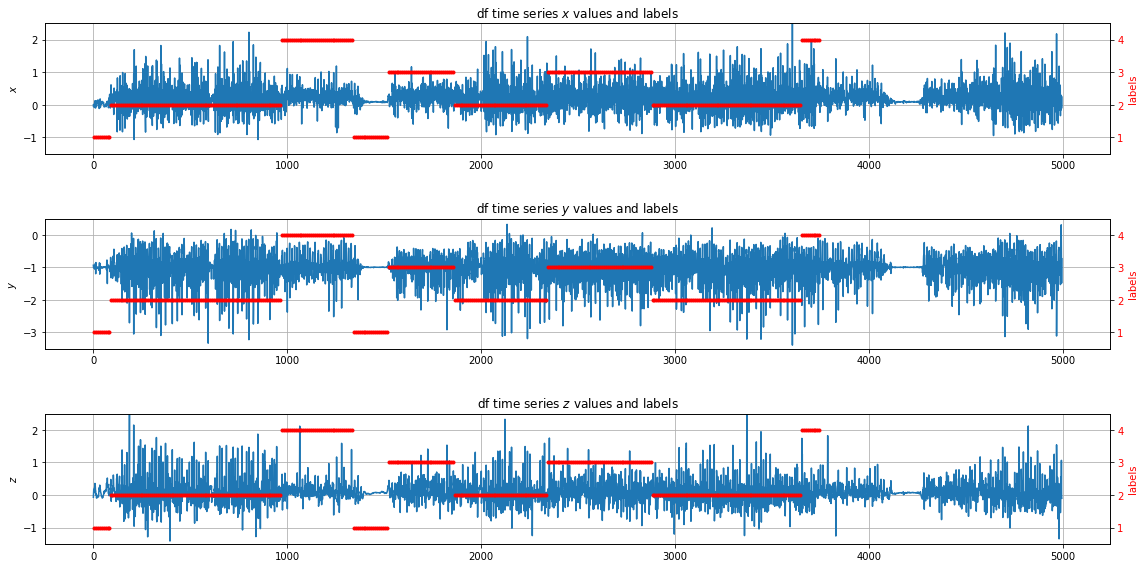

In [18]:
# Display of x-y-z signals against labels or activities.

fig, (ax1, ax2, ax3) = plt.subplots(3)

# Plot x signal 
ax1.plot(df["x"])
ax1.grid(True)
ax1.set_ylim((-1.5, 2.5))
ax1.set_ylabel("$x$")
ax1.set_title("df time series $x$ values and labels")

ax11 = ax1.twinx()  # instantiate a second axis that shares the same x-axis
ax11.set_ylim((0.5, 4.5))
ax11.set_ylabel("labels", color = "red")
ax11.plot(df["label"], color = "red", marker = ".")
ax11.tick_params(axis = "y", labelcolor = "red")
fig.tight_layout()  

# Plot y signal
ax2.plot(df["y"])
ax2.grid(True)
ax2.set_ylim((-3.5, 0.5))
ax2.set_ylabel("$y$")
ax2.set_title("df time series $y$ values and labels")

ax21 = ax2.twinx()  # instantiate a second axis that shares the same x-axis
ax21.set_ylim((0.5, 4.5))
ax21.set_ylabel("labels", color = "red")
ax21.plot(df["label"], color = "red", marker = ".")
ax21.tick_params(axis = "y", labelcolor = "red")
fig.tight_layout()  

# Plot z signal
ax3.plot(df["z"])
ax3.grid(True)
ax3.set_ylim((-1.5, 2.5))
ax3.set_ylabel("$z$")
ax3.set_title("df time series $z$ values and labels")

ax31 = ax3.twinx()  # instantiate a second axis that shares the same x-axis
ax31.set_ylim((0.5, 4.5))
ax31.set_ylabel("labels", color = "red")
ax31.plot(df["label"], color = "red", marker = ".")
ax31.tick_params(axis = "y", labelcolor = "red")
fig.tight_layout()  

plt.subplots_adjust(hspace = 0.5)

#Insights:
Signal y looks to have an offset of -1 compared to signals x and z.
Class 1: standing (static activity) is pretty flat in all 3-direction signals.
Difficult to discriminate here the three other classes, 2: walking, 3: stairs down, and 4: stairs up, which are dynamic activities. However, it seems that the signals noise is bigger for class 2 than classes 3 and 4, but something doesn't fit well at the transition around observation #2000. There is a transition between class 3 and class 2 occurring at observations around #1800-#1900 but the signals show a change rather at observations around #2000.
The type of activities can be separated/classified by observing the data for static and dynamic activities but more problematic within dynamic activities group itself.

We may already note here a clear imbalance among our labels/classes. Class 2 has many more occurrences than class 1 for example.

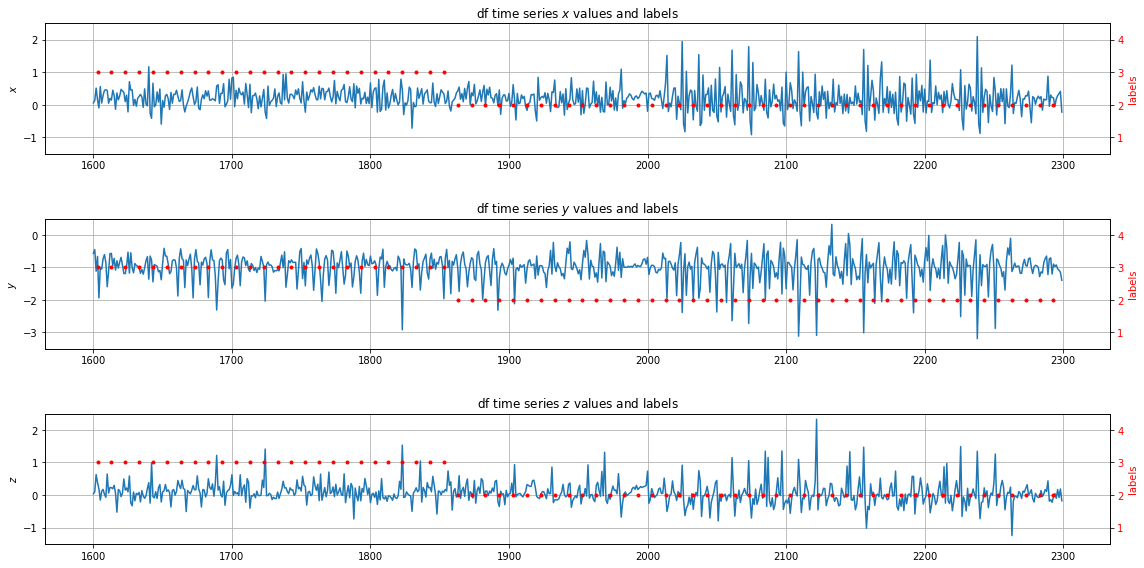

In [19]:
# Zoom in x-y-z signals between observations #1600 and #2300 against labels or activities.

fig, (ax1, ax2, ax3) = plt.subplots(3)

# Plot x signal 
ax1.plot(df["x"][1600:2300])
ax1.grid(True)
ax1.set_ylim((-1.5, 2.5))
ax1.set_ylabel("$x$")
ax1.set_title("df time series $x$ values and labels")

ax11 = ax1.twinx()  # instantiate a second axis that shares the same x-axis
ax11.set_ylim((0.5, 4.5))
ax11.set_ylabel("labels", color = "red")
ax11.plot(df["label"][1600:2300], color = "red", marker = ".")
ax11.tick_params(axis = "y", labelcolor = "red")
fig.tight_layout()  

# Plot y signal
ax2.plot(df["y"][1600:2300])
ax2.grid(True)
ax2.set_ylim((-3.5, 0.5))
ax2.set_ylabel("$y$")
ax2.set_title("df time series $y$ values and labels")

ax21 = ax2.twinx()  # instantiate a second axis that shares the same x-axis
ax21.set_ylim((0.5, 4.5))
ax21.set_ylabel("labels", color = "red")
ax21.plot(df["label"][1600:2300], color = "red", marker = ".")
ax21.tick_params(axis = "y", labelcolor = "red")
fig.tight_layout()  

# Plot z signal
ax3.plot(df["z"][1600:2300])
ax3.grid(True)
ax3.set_ylim((-1.5, 2.5))
ax3.set_ylabel("$z$")
ax3.set_title("df time series $z$ values and labels")

ax31 = ax3.twinx()  # instantiate a second axis that shares the same x-axis
ax31.set_ylim((0.5, 4.5))
ax31.set_ylabel("labels", color = "red")
ax31.plot(df["label"][1600:2300], color = "red", marker = ".")
ax31.tick_params(axis = "y", labelcolor = "red")
fig.tight_layout()  

plt.subplots_adjust(hspace = 0.5)

Insights:
Strange...the transition between class 3 and class 2 occurs at observations around #1850 while the accelerometer signals in the 3 directions would rather indicate a transition at observations around #2000. In order to understand that, we would need more information about how the labelling was performed.



## Feature Engineering

Let's define a few additional features to our data.

Rolling averages for:

signals x, y, z

magnitude (x, y, z combined)

Rolling standards deviations for:

signals x, y, z
magnitude
Energies of signals x, y, z.

As we have a labelling every 10th observation, let's use a time window of 5 observations, as a tradeoff between signal aggregation/smoothing and response time.

In [20]:
# Let's make a copy of our df for the feature engineering as we can expect many back and forth in the process.
df_eng = df.copy()

In [21]:
# Rolling averages
df_eng["x_mean"] = df_eng["x"][4:].rolling(window = 5).mean() # start at the 4th row to synchronize with labelling
df_eng["y_mean"] = (df_eng["y"][4:]+1).rolling(window = 5).mean() # offset removed for y signal
df_eng["z_mean"] = df_eng["z"][4:].rolling(window = 5).mean()

# Rolling standard deviations
df_eng["x_sd"] = df_eng["x"][4:].rolling(window = 5).std()
df_eng["y_sd"] = (df_eng["y"][4:]+1).rolling(window = 5).std() 
df_eng["z_sd"] = df_eng["z"][4:].rolling(window = 5).std()

# 3D-amplitude rolling averages
df_eng["magnitude"] = np.sqrt(df_eng["x"]**2 + (df_eng["y"]+1)**2 + df_eng["z"]**2) 
df_eng["m_mean"] = df_eng["magnitude"][4:].rolling(window = 5).mean()

# 3D-amplitude rolling standard deviations
df_eng["m_sd"] = df_eng["magnitude"][4:].rolling(window = 5).std()

# Energy which is related to the frequency of the signal according to the Parseval's theorem
df_eng["x_E"] = (df_eng["x"][4:]**2).rolling(window = 5).sum()
df_eng["y_E"] = ((df_eng["y"][4:]+1)**2).rolling(window = 5).sum() 
df_eng["z_E"] = (df_eng["z"][4:]**2).rolling(window = 5).sum()

More information about the Parseval's theorem https://en.wikipedia.org/wiki/Parseval%27s_theorem'.

In [22]:
df_eng

,timestamp,x,y,z,label,x_mean,y_mean,z_mean,x_sd,y_sd,z_sd,magnitude,m_mean,m_sd,x_E,y_E,z_E
0,1565109930787,-0.006485,-0.934860,-0.069046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.095145,NaN,NaN,NaN,NaN,NaN
1,1565109930887,-0.066467,-1.015442,0.089554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.112589,NaN,NaN,NaN,NaN,NaN
2,1565109930987,-0.043488,-1.021255,0.178467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.184914,NaN,NaN,NaN,NaN,NaN
3,1565109931087,-0.053802,-0.987701,0.068985,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.088345,NaN,NaN,NaN,NaN,NaN
4,1565109931188,-0.054031,-1.003616,0.126450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.137557,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4989,1565110430975,0.036499,-0.724823,0.553802,NaN,0.130811,0.118738,0.016656,0.348468,0.438107,0.411148,0.619477,0.631253,0.153850,0.571276,0.838244,0.677559
4990,1565110431075,-0.159241,0.307022,0.142410,NaN,-0.021384,0.382886,0.001117,0.240971,0.673304,0.402922,1.324366,0.767952,0.346972,0.234554,2.546363,0.649392
4991,1565110431175,-0.037964,-0.673706,1.065445,NaN,0.038455,0.554211,0.322531,0.169503,0.457117,0.492716,1.114936,0.825013,0.381403,0.122319,2.371576,1.491207
4992,1565110431275,0.255707,-1.485397,-0.013336,NaN,0.029044,0.417581,0.353714,0.151510,0.651193,0.457485,0.548794,0.854917,0.343673,0.096039,2.568080,1.462739


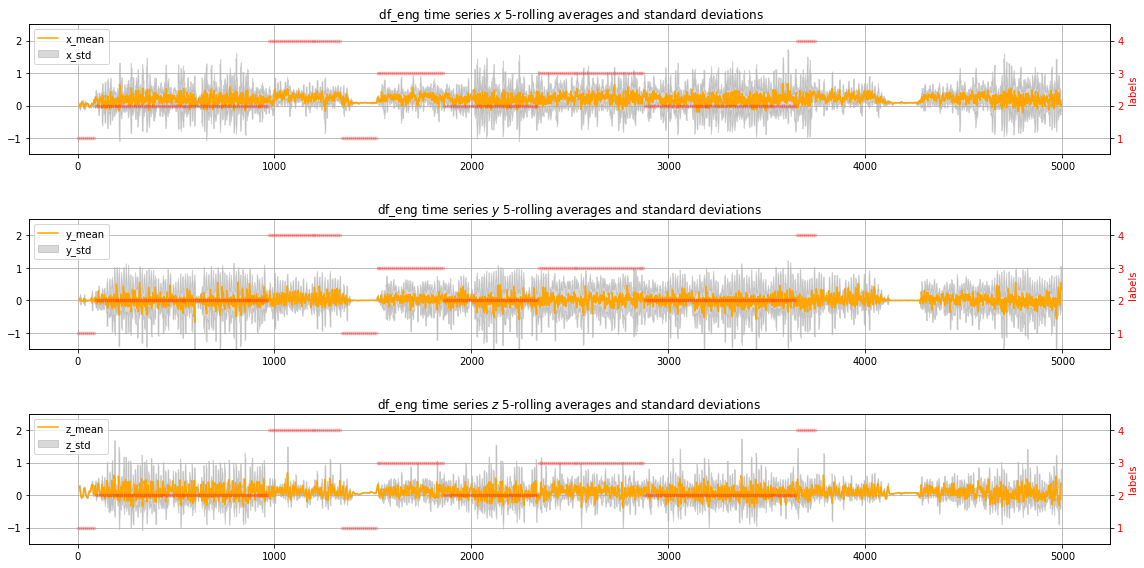

In [23]:
# Visualization of x, y, z rolling averages with their standard deviations vs. labels.

fig, (ax1, ax2, ax3) = plt.subplots(3)

# Plot x_mean signal and standard deviations
ax1.grid(True)
ax1.set_ylim((-1.5, 2.5))
ax1.plot(df_eng["x_mean"], label = "x_mean", color = "orange")
ax1.fill_between(df_eng.index,
                 df_eng["x_mean"] - df_eng["x_sd"],
                 df_eng["x_mean"] + df_eng["x_sd"],
                 alpha = 0.3, label = "x_std", color = "grey")
ax1.legend(loc = "upper left")
ax1.set_title(" df_eng time series $x$ 5-rolling averages and standard deviations")

ax11 = ax1.twinx()  
ax11.set_ylim((0.5, 4.5))
ax11.set_ylabel("labels", color = "red")
ax11.plot(df_eng["label"], alpha = 0.15, color = "red", linestyle = "None", marker = ".")
ax11.tick_params(axis = "y", labelcolor = "red")
fig.tight_layout() 

# Plot y_mean signal and standard deviations
ax2.grid(True)
ax2.set_ylim((-1.5, 2.5))
ax2.plot(df_eng["y_mean"], label = "y_mean", color = "orange")
ax2.fill_between(df_eng.index,
                 df_eng["y_mean"] - df_eng["y_sd"],
                 df_eng["y_mean"] + df_eng["y_sd"],
                 alpha = 0.3, label = "y_std", color = "grey")
ax2.legend(loc = "upper left")
ax2.set_title("df_eng time series $y$ 5-rolling averages and standard deviations")

ax21 = ax2.twinx()  
ax21.set_ylim((0.5, 4.5))
ax21.set_ylabel("labels", color = "red")
ax21.plot(df_eng["label"], alpha = 0.15, color = "red", linestyle = "None", marker = ".")
ax21.tick_params(axis = "y", labelcolor = "red")
fig.tight_layout() 

# Plot z_mean signal and standard deviations
ax3.grid(True)
ax3.set_ylim((-1.5, 2.5))
ax3.plot(df_eng["z_mean"], label = "z_mean", color = "orange")
ax3.fill_between(df_eng.index,
                 df_eng["z_mean"] - df_eng["z_sd"],
                 df_eng["z_mean"] + df_eng["z_sd"],
                 alpha = 0.3, label = "z_std", color = "grey")
ax3.legend(loc = "upper left")
ax3.set_title("df_eng time series $z$ 5-rolling averages and standard deviations")

ax31 = ax3.twinx()  
ax31.set_ylim((0.5, 4.5))
ax31.set_ylabel("labels", color = "red")
ax31.plot(df_eng["label"], alpha = 0.15, color = "red", linestyle = "None", marker = ".")
ax31.tick_params(axis = "y", labelcolor = "red")
fig.tight_layout() 

plt.subplots_adjust(hspace = 0.5)

Insights:
x, y, and z averages and standard deviations are flat with class 1, especially for standard deviations, as expected.

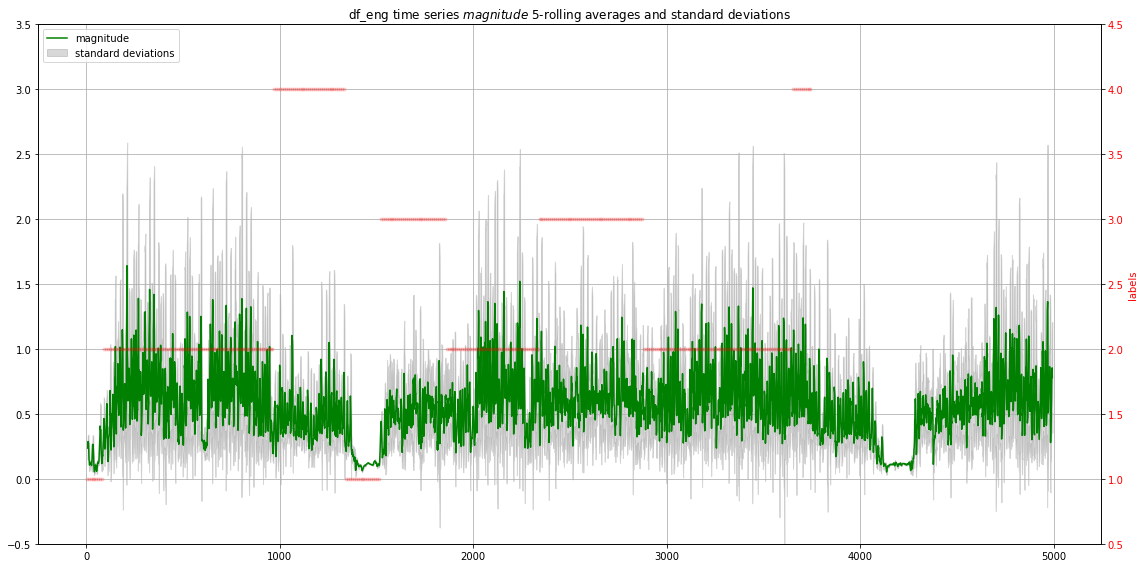

In [24]:
# Visualization of magnitude rolling averages with their standard deviations vs. labels.

fig, (ax1) = plt.subplots(1)

ax1.grid(True)
ax1.set_ylim((-0.5, 3.5))
ax1.plot(df_eng["m_mean"], label = "magnitude", color = "green")
ax1.fill_between(df_eng.index,
                 df_eng["m_mean"] - df_eng["m_sd"],
                 df_eng["m_mean"] + df_eng["m_sd"],
                 alpha = 0.3, label = "standard deviations", color = "grey")
ax1.legend(loc = "upper left")
ax1.set_title("df_eng time series $magnitude$ 5-rolling averages and standard deviations")

ax11 = ax1.twinx()  
ax11.set_ylim((0.5, 4.5))
ax11.set_ylabel("labels", color = "red")
ax11.plot(df_eng["label"], alpha = 0.15, color = "red", linestyle = "None", marker = ".")
ax11.tick_params(axis = "y", labelcolor = "red")
fig.tight_layout()

Insights
Magnitude is flat with class 1.
Magnitude seems a bit higher for class 2 than for classes 3 and 4.
Its more difficult to discriminate class 3 and class 4 from observing the data here.
We particularly notice a lag between the signal and the label/class at transitions.


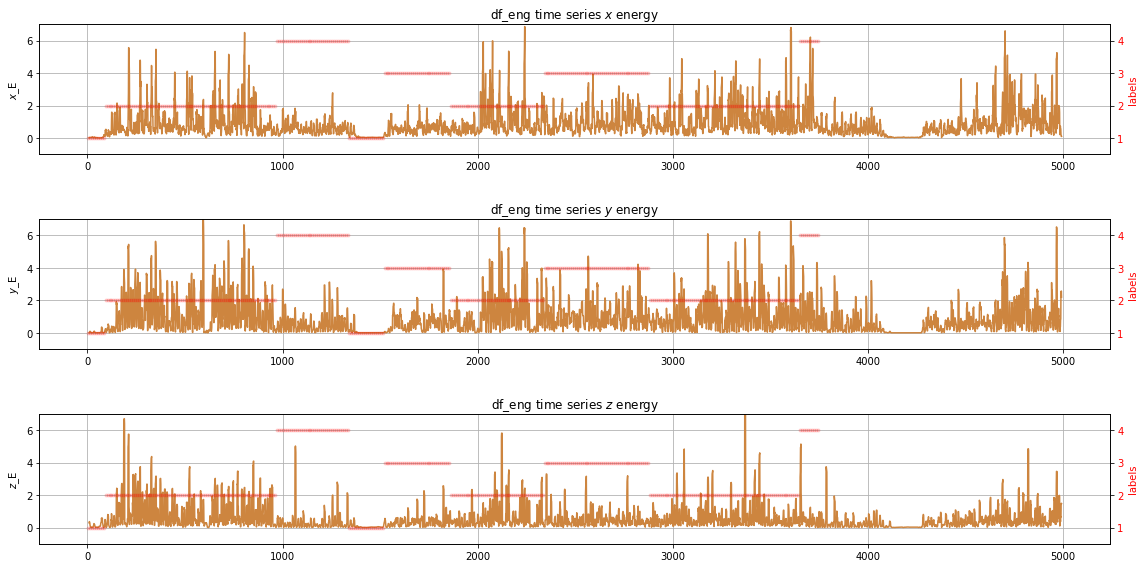

In [25]:
# Visualization of  x, y, z signals energy vs. labels.

fig, (ax1, ax2, ax3) = plt.subplots(3)

# Plot x signal energy
ax1.grid(True)
ax1.set_ylim((-1, 7))
ax1.plot(df_eng["x_E"], color = "peru")
ax1.set_ylabel("$x$_E")
ax1.set_title("df_eng time series $x$ energy")

ax11 = ax1.twinx()  
ax11.set_ylim((0.5, 4.5))
ax11.set_ylabel("labels", color = "red")
ax11.plot(df_eng["label"], alpha = 0.15, color = "red", linestyle = "None", marker = ".")
ax11.tick_params(axis = "y", labelcolor = "red")
fig.tight_layout() 

# Plot y signal energy
ax2.grid(True)
ax2.set_ylim((-1, 7))
ax2.plot(df_eng["y_E"], color = "peru")
ax2.set_ylabel("$y$_E")
ax2.set_title("df_eng time series $y$ energy")

ax21 = ax2.twinx()  
ax21.set_ylim((0.5, 4.5))
ax21.set_ylabel("labels", color = "red")
ax21.plot(df_eng["label"], alpha = 0.15, color = "red", linestyle = "None", marker = ".")
ax21.tick_params(axis = "y", labelcolor = "red")
fig.tight_layout() 

# Plot z signal energy
ax3.grid(True)
ax3.set_ylim((-1, 7))
ax3.plot(df_eng["z_E"], color = "peru")
ax3.set_ylabel("$z$_E")
ax3.set_title("df_eng time series $z$ energy")

ax31 = ax3.twinx()  
ax31.set_ylim((0.5, 4.5))
ax31.set_ylabel("labels", color = "red")
ax31.plot(df_eng["label"], alpha = 0.15, color = "red", linestyle = "None", marker = ".")
ax31.tick_params(axis = "y", labelcolor = "red")
fig.tight_layout() 

plt.subplots_adjust(hspace = 0.5)

Insights
Energy is definitely flat for class 1.
Energy is higher for class 2, clear for observations before #2000 but less clear for observations after.
Energy for class 3 seems a bit higher than for class 4, less obvious for observations after #2000.

## Building classification models

Prepping our datasets.
Let's split our engineered dataframe to find back our initial X_train set (with labels) and X_test set (without labels) but now with additional features.

In [26]:
split_time = 1565110306139
X_train = df_eng.loc[df_eng["timestamp"] < split_time]
X_test = df_eng.loc[df_eng["timestamp"] >= split_time]

In [27]:
print("X_train: \n%s" % X_train, "\n")
print("X_test: \n%s" % X_test)

X_train: 
          timestamp         x         y         z  label    x_mean    y_mean  \
0     1565109930787 -0.006485 -0.934860 -0.069046    NaN       NaN       NaN   
1     1565109930887 -0.066467 -1.015442  0.089554    NaN       NaN       NaN   
2     1565109930987 -0.043488 -1.021255  0.178467    NaN       NaN       NaN   
3     1565109931087 -0.053802 -0.987701  0.068985    1.0       NaN       NaN   
4     1565109931188 -0.054031 -1.003616  0.126450    NaN       NaN       NaN   
...             ...       ...       ...       ...    ...       ...       ...   
3739  1565110305638  0.024384 -0.710709  0.030304    NaN  0.381805 -0.003494   
3740  1565110305738  0.487228 -1.099136 -0.015213    NaN  0.348709 -0.015271   
3741  1565110305838  0.369446 -0.968506  0.036713    NaN  0.408737 -0.128214   
3742  1565110305939  0.167877 -0.802826  0.049805    NaN  0.377667 -0.267410   
3743  1565110306039  0.689346 -0.991043  0.034973    4.0  0.347656  0.085556   

        z_mean      x_sd     

In [28]:
# Drop rows with NaN values in X_train set.
X_train = X_train.dropna(how = "any")
X_train.reset_index(drop = True, inplace = True)

# Drop "label" column from X_test set and merge with the original label set, i.e. y_test.
X_test = X_test.drop(labels = "label", axis = 1)
X_test = X_test.merge(y_test, how = "right", left_on = "timestamp", right_on = "timestamp")

In [29]:
print("X_train: \n%s" % X_train, "\n")
print("X_test: \n%s" % X_test)

X_train: 
         timestamp         x         y         z  label    x_mean    y_mean  \
0    1565109932090  0.013718 -0.852371 -0.000870    1.0 -0.017218  0.052502   
1    1565109933092  0.145584 -1.007843 -0.036819    1.0  0.096811  0.000986   
2    1565109934094 -0.099380 -1.209686  0.304489    1.0 -0.065198  0.007608   
3    1565109935097  0.082794 -1.001434 -0.025375    1.0  0.036398 -0.003287   
4    1565109936099  0.037582 -0.998383  0.019333    1.0  0.050793 -0.004266   
..             ...       ...       ...       ...    ...       ...       ...   
369  1565110302030 -0.641953 -1.469177  0.301041    4.0  0.280923 -0.130682   
370  1565110303032 -0.171616 -0.366074 -0.059082    4.0  0.052682  0.076358   
371  1565110304034  0.401810 -1.077698  0.258911    4.0  0.209601 -0.136621   
372  1565110305037  0.330338 -1.470062  0.303894    4.0  0.366956 -0.035223   
373  1565110306039  0.689346 -0.991043  0.034973    4.0  0.347656  0.085556   

       z_mean      x_sd      y_sd      z_

Our datasets have been reduced to 1/10 of the original observations. Hopefully, we have not lost useful information.

In [30]:
X_train.isnull().any()

timestamp    False
x            False
y            False
z            False
label        False
x_mean       False
y_mean       False
z_mean       False
x_sd         False
y_sd         False
z_sd         False
magnitude    False
m_mean       False
m_sd         False
x_E          False
y_E          False
z_E          False
dtype: bool

In [31]:
X_test.isnull().any()

timestamp    False
x            False
y            False
z            False
x_mean       False
y_mean       False
z_mean       False
x_sd         False
y_sd         False
z_sd         False
magnitude    False
m_mean       False
m_sd         False
x_E          False
y_E          False
z_E          False
label         True
dtype: bool

#Imbalanced classes

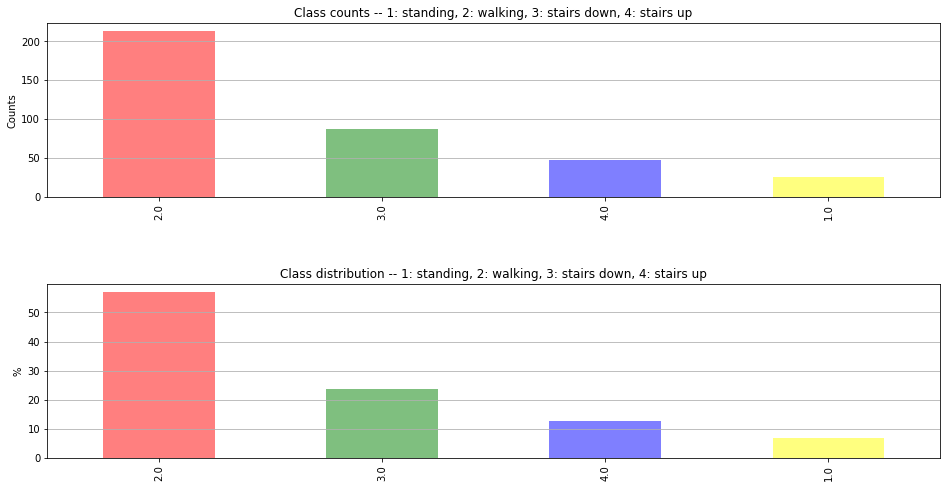

In [32]:
# Visualization of classes balance.

clist = ["red", "green", "blue", "yellow"]

fig, (ax1, ax2) = plt.subplots(2)

X_train["label"].value_counts().plot(kind = "bar", color = clist, alpha = 0.5, ax = ax1)
ax1.yaxis.grid(True)
ax1.set_ylabel("Counts")
ax1.set_title("Class counts -- 1: standing, 2: walking, 3: stairs down, 4: stairs up")

distrib = X_train["label"].value_counts(normalize = True)*100.00
distrib.plot(kind = "bar", color = clist, alpha = 0.5, ax = ax2)
ax2.yaxis.grid(True)
ax2.set_ylabel("%")
ax2.set_title("Class distribution -- 1: standing, 2: walking, 3: stairs down, 4: stairs up")

plt.subplots_adjust(hspace = 0.5)

Insights:
Our X_train dataset clearly shows imbalanced classes, which will be a real Machine Learning challenge to address, in addition to the very few quantity of data that we are provided with.

##Splitting data

Let's split now our X_train set into to one training set and one testing set with a ratio of 75/25 for building our models.

In [33]:
mod_train = X_train.iloc[0:int(len(X_train)*0.75)]
mod_test = X_train.iloc[int(len(X_train)*0.75):len(X_train)]

In [34]:
print("mod_train: \n%s" % mod_train, "\n")
print("mod_test: \n%s" % mod_test)

mod_train: 
         timestamp         x         y         z  label    x_mean    y_mean  \
0    1565109932090  0.013718 -0.852371 -0.000870    1.0 -0.017218  0.052502   
1    1565109933092  0.145584 -1.007843 -0.036819    1.0  0.096811  0.000986   
2    1565109934094 -0.099380 -1.209686  0.304489    1.0 -0.065198  0.007608   
3    1565109935097  0.082794 -1.001434 -0.025375    1.0  0.036398 -0.003287   
4    1565109936099  0.037582 -0.998383  0.019333    1.0  0.050793 -0.004266   
..             ...       ...       ...       ...    ...       ...       ...   
275  1565110207814  0.286728 -0.772873  0.004883    3.0  0.217883 -0.136908   
276  1565110208816 -0.554367 -1.945923 -0.351334    3.0  0.096323 -0.050458   
277  1565110209818  0.732361 -0.938477 -0.078278    3.0  0.226181  0.161777   
278  1565110210821  0.257874 -0.615005  0.031891    3.0  0.331747  0.339182   
279  1565110211823  0.275391 -0.700226  0.007645    3.0  0.076016  0.122168   

       z_mean      x_sd      y_sd      

In [35]:
print("mod_train class counts: \n%s" % mod_train["label"].value_counts(), "\n")
print("mod_test class counts: \n%s" % mod_test["label"].value_counts())

mod_train class counts: 
2.0    136
3.0     81
4.0     37
1.0     26
Name: label, dtype: int64 

mod_test class counts: 
2.0    77
4.0    10
3.0     7
Name: label, dtype: int64


Choosing the right Metric
Let's check the accuracy we would get if we guessed the most common class, here class 2, for every observation, that is the best we could do without any information about features, but information about true labels of the test set.

In [36]:
# Informed guess! 
print("\"Informed guess\" accuracy:", mod_test["label"].value_counts().values[0] / mod_test["label"].value_counts().values.sum())

"Informed guess" accuracy: 0.8191489361702128


When we look at multiclass classifiers, the overall accuracy (i.e. y_true == y_pred) is interesting, but doesn't show us if we're making more mistakes on one class or another. It is not a relevant metric for adressing imbalanced classes, as it especially down-weights mistakes on minority classes. So let's also look at other alternative metrics.

Alternative metrics could be:

Precision/Specificity: Measure of a classifier exactness, how many selected observations are correct.

Recall/Sensitivity: Measure of a classifier completeness, how many correct observations are selected.

F1 score: Weighted average of precision and recall.

Area Under Curve: Relation between true positives rate and false positives rate.

Matrix Confusion: A breakdown of predictions into a table showing correct predictions (the diagonal) and the types of * incorrect predictions made (what classes incorrect predictions were assigned).

Let's see what would be the confusion matrix here if our predictions were only the most common class.

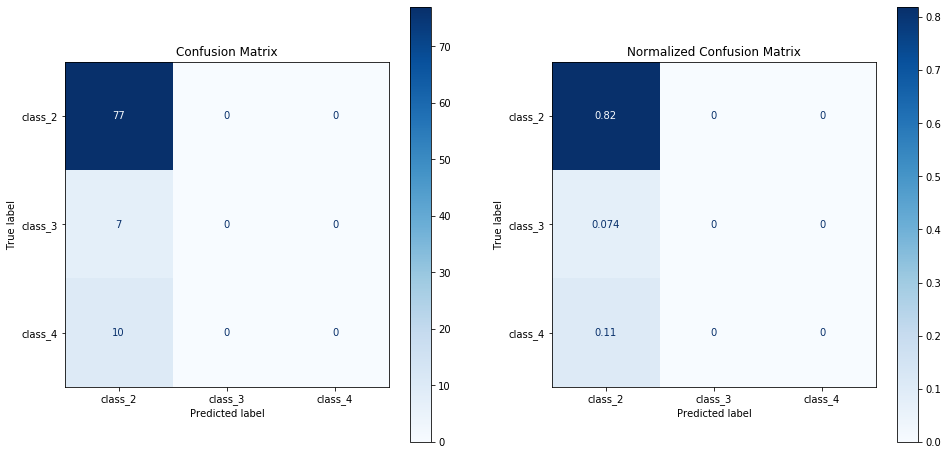

In [37]:
# Confusion matrix

test_array = np.array(mod_test["label"])
pred_array = np.full(len(test_array), 2.0)

cm = confusion_matrix(test_array, pred_array)
cm_normalized = ((confusion_matrix(test_array, pred_array))/len(test_array))

fig, (ax1, ax2) = plt.subplots(1, 2)

class_names = ["class_2", "class_3", "class_4"]

ConfusionMatrixDisplay(confusion_matrix = cm, \
                       display_labels = class_names).plot(include_values = True, cmap = plt.cm.Blues, ax = ax1)
ax1.set_title("Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix = cm_normalized, \
                       display_labels = class_names).plot(include_values = True, cmap = plt.cm.Blues, ax = ax2)
ax2.set_title("Normalized Confusion Matrix");

If we were only guessing the most common class, in spite of an overall accuracy of 82%, which is inherently good, the confusion matrix shows that we predict poorly for the other classes than the majority class. Also, the F1 score is a quick metric more relevant in our case of imbalanced classes. The F1 score can be interpreted as a weighted average of the precision and recall. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is: F1 = 2 (precision recall) / (precision + recall).

In [38]:
print("\"Informed guess\" F1 score:", f1_score(test_array, pred_array, average = "weighted"))

"Informed guess" F1 score: 0.7377130770187882


So our "informed guess", which could be our baseline, F1 score is 0.7377. Having that said, EdX uses another scoring method for this project, based on accuracy. So let's define a function that emulates EdX scoring.

In [39]:
def edx_scoring(predicted, true):
    score = []
    matches = 0
    if predicted.shape != true.shape:
        print("predicted labels and true labels must have same size")
    else:
        for x,y in zip(predicted, true):
            if x == y:
                matches += 1
    score.append(np.round(matches/true.shape[0],4)) # Calculate the score for accuracy to 4 decimal places
    return score[0]

In [40]:
# Let's try edx_scoring on our "informed guess" example
print("The EdX accuracy for this model is %.2f%%" % np.round(edx_scoring(pred_array, test_array)*100.00, 5))

The EdX accuracy for this model is 81.91%


##Scikit-learn classifiers

In this project, we will use classifiers from the scikit-learn package. Please ensure that the latest version 0.22 (or greater) is installed, before running the cells below.

Let's define:

A function predict_F1 that predicts the classes of a test set and compute the F1 score.
A function eval_cm that uses the function predict_F1 to display a normalized confusion matrix.
The classifiers that we will test are:

Logistic Regression
Nearest Neighbors
Random Forest
Gradient Boosting
Note on cross-validation: Most general cross-validation techniques are not correct when it comes to time series. Bootstrapping resampling, k-fold or stratified k-fold shuffles the data and does not ensure that there is the same coherence in validation folds as compared to the actual test set.

Therefore, we will use the scikit-learn time series cross-validator to ensure a proper time series cross-validation split.

## Cross Validation

Observations: 96
Training Observations: 50
Testing Observations: 46
Observations: 142
Training Observations: 96
Testing Observations: 46
Observations: 188
Training Observations: 142
Testing Observations: 46
Observations: 234
Training Observations: 188
Testing Observations: 46
Observations: 280
Training Observations: 234
Testing Observations: 46


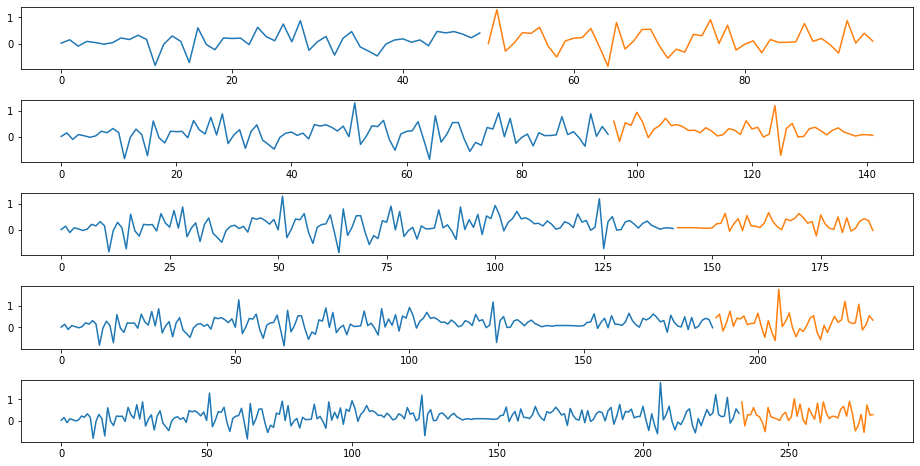

In [41]:
# scikit-learn time series cross-validator. 
tscv = TimeSeriesSplit(n_splits = 5) 

# Example of TimeSeriesSplit on x signal
X = np.array(mod_train["x"])
index = 1
plt.figure(1)
for train_index, test_index in tscv.split(X):
	train = X[train_index]
	test = X[test_index]
	print('Observations: %d' % (len(train) + len(test)))
	print('Training Observations: %d' % (len(train)))
	print('Testing Observations: %d' % (len(test)))
	plt.subplot(510 + index)
	plt.plot(train)
	plt.plot([None for i in train] + [ii for ii in test])
	index += 1
plt.subplots_adjust(hspace = 0.5)

### Defined-functions for building models

In [42]:
def predict_F1(estimator, covariates, X, Y):
    """
    This function takes estimator: classifier, covariates: array of features, 
    X: train set including labels, Y: test set including labels.
    It computes and returns the best estimator, predictions and F1 score.
    """
    train_covariates = X[covariates]
    train_labels = X["label"].astype("int")
    test_covariates = Y[covariates]
    test_labels = Y["label"].astype("int")
    
    if (estimator == LogisticRegression):
        lrc = estimator(class_weight = "balanced", random_state = 699, max_iter = 1000) # class_weight = "balanced" for unbalanced datasets
        param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
        lrc_grid = GridSearchCV(lrc, param_grid, scoring = "f1_weighted", cv = tscv)
        lrc_grid.fit(train_covariates, train_labels);
        best_lrc = lrc_grid.best_estimator_
        # evaluating
        lrc_predictions = best_lrc.fit(train_covariates, train_labels).predict(test_covariates)
        F1_score = f1_score(test_labels, lrc_predictions, average = "weighted")
        return (best_lrc, lrc_predictions, F1_score)
    
    elif (estimator == KNeighborsClassifier):
        knn = estimator()
        param_grid = {"n_neighbors": [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                      "weights": ["uniform", "distance"], "p": [1, 2, 5]}
        knn_grid = GridSearchCV(knn, param_grid, scoring = "f1_weighted", cv = tscv)
        knn_grid.fit(train_covariates, train_labels);
        best_knn = knn_grid.best_estimator_
        # evaluating
        knn_predictions = best_knn.fit(train_covariates, train_labels).predict(test_covariates)
        F1_score = f1_score(test_labels, knn_predictions, average = "weighted")
        return (best_knn, knn_predictions, F1_score)
    
        
    elif (estimator == RandomForestClassifier):
        rfc = estimator(class_weight = "balanced", random_state = 699) # class_weight = "balanced" for unbalanced datasets
        param_grid = {"n_estimators": [10, 20, 60, 100], "criterion": ["gini", "entropy"], "max_depth": [6, 8, 12, 16]}
        rfc_grid = GridSearchCV(rfc, param_grid, scoring = "f1_weighted", cv = tscv)
        rfc_grid.fit(train_covariates, train_labels);
        best_rfc = rfc_grid.best_estimator_
        # Evaluating
        rfc_predictions = best_rfc.fit(train_covariates, train_labels).predict(test_covariates)
        F1_score = f1_score(test_labels, rfc_predictions, average = "weighted")
        return (best_rfc, rfc_predictions, F1_score)            
        
    elif (estimator == GradientBoostingClassifier):
        gbc = estimator(random_state = 699) 
        param_grid = {"n_estimators": [10, 20, 60, 100], "max_depth": [6, 8, 12, 16]}
        gbc_grid = GridSearchCV(gbc, param_grid, scoring = "f1_weighted", cv = tscv)
        gbc_grid.fit(train_covariates, train_labels);
        best_gbc = gbc_grid.best_estimator_
        # Evaluating
        gbc_predictions = best_gbc.fit(train_covariates, train_labels).predict(test_covariates)
        F1_score = f1_score(test_labels, gbc_predictions, average = "weighted")
        return (best_gbc, gbc_predictions, F1_score)

In [43]:
def eval_cm(estimator, covariates, X, Y):
    """
    This function takes estimator: classifier, covariates: array of features, 
    X: train set including labels, Y: test set including labels.
    It shows F1 score, predictions and a normalized confusion matrix.
    """
    #train_covariates = X[covariates]
    #train_labels = X["label"].astype("int").astype("category")
    test_covariates = Y[covariates]
    test_labels = Y["label"].astype("int")
        
    if (estimator == LogisticRegression):
        best_lrc, lrc_predictions, F1_score = predict_F1(estimator, covariates, X, Y)        
        print("F1 score:", F1_score)
        print("classes counts: \n%s" % np.array(np.unique(lrc_predictions, return_counts = True)))
        classes = list(np.array(np.unique(lrc_predictions, return_counts = True))[0])
        title ="Logistic Regression normalized Confusion Matrix"
        disp = plot_confusion_matrix(best_lrc, test_covariates, test_labels, display_labels = classes,
                                     cmap = plt.cm.Blues, normalize = "pred")
        disp.ax_.set_title(title);
    
    elif (estimator == KNeighborsClassifier):
        best_knn, knn_predictions, F1_score = predict_F1(estimator, covariates, X, Y)        
        print("F1 score:", F1_score)
        print("classes counts: \n%s" % np.array(np.unique(knn_predictions, return_counts = True)))
        classes = list(np.array(np.unique(knn_predictions, return_counts = True))[0])
        title ="Nearest Neighbors normalized Confusion Matrix"
        disp = plot_confusion_matrix(best_knn, test_covariates, test_labels, display_labels = classes,
                                     cmap = plt.cm.Blues, normalize = "pred")
        disp.ax_.set_title(title);
        
    elif (estimator == RandomForestClassifier):
        best_rfc, rfc_predictions, F1_score = predict_F1(estimator, covariates, X, Y)
        print("F1 score:", F1_score)
        print("classes counts: \n%s" % np.array(np.unique(rfc_predictions, return_counts = True)))
        classes = list(np.array(np.unique(rfc_predictions, return_counts = True))[0])
        title ="Random Forest Classifier normalized Confusion Matrix"
        disp = plot_confusion_matrix(best_rfc, test_covariates, test_labels, display_labels = classes,
                                     cmap = plt.cm.Blues, normalize = "pred")
        disp.ax_.set_title(title);               
        
    elif (estimator == GradientBoostingClassifier):
        best_gbc, gbc_predictions, F1_score = predict_F1(estimator, covariates, X, Y)
        print("F1 score:", F1_score)
        print("classes counts: \n%s" % np.array(np.unique(gbc_predictions, return_counts = True)))
        classes = list(np.array(np.unique(gbc_predictions, return_counts = True))[0])
        title ="Gradient Boosting Classifier normalized Confusion Matrix"
        disp = plot_confusion_matrix(best_gbc, test_covariates, test_labels, display_labels = classes,
                                     cmap = plt.cm.Blues, normalize = "pred")
        disp.ax_.set_title(title);

We will apply to each of the classifiers 3 data setups:

Using initial features, i.e. x, y, and z raw signals,
Using features relevant to time and frequency characteristics of the signals,

Averages of signals x, y, and z
Energies of signals x, y, and z
Using all of the aggregated features

Averages of signals x, y, and z
Standard deviations of signals x, y, and z
Averages of x-y-z magnitude
Standard deviations of x-y-z magnitude
Energies of signals x, y, and z.
So in total, we have 12 models, 3 models for each of the 4 classifiers.

### Logistic Regression classifier

In [44]:
# Logistic Regression - Model 1.1
raw_covariates = ["x", "y", "z"] 
mod1_best, mod1_preds, mod1_F1  = predict_F1(LogisticRegression, raw_covariates, mod_train, mod_test)

# Create a table that's going to store the results that we obtain as we're going to compare different models.
mod_test_labels = np.array(mod_test["label"].astype(int))
results = pd.DataFrame(np.array([["LR with x, y, z raw signals", np.round(mod1_F1, 5),
                                  np.round(edx_scoring(mod1_preds, mod_test_labels), 5)]]),
                                  columns = ["Model", "F1_score", "EdX accuracy"])
print(results)

                         Model F1_score EdX accuracy
0  LR with x, y, z raw signals  0.15933       0.1489


F1 score: 0.15933441391903813
classes counts: 
[[ 1  2  3  4]
 [33  8  2 51]]


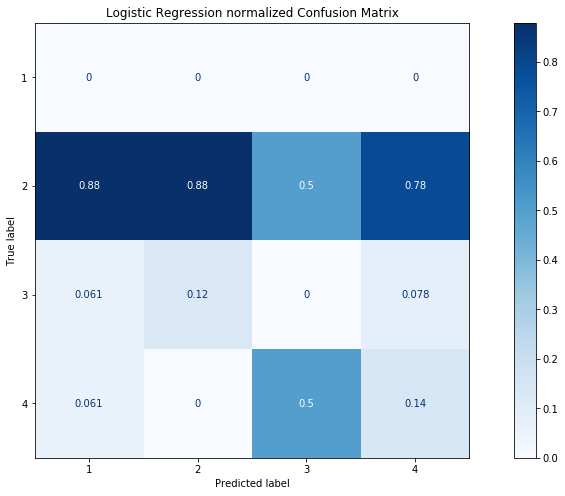

In [45]:
eval_cm(LogisticRegression, raw_covariates, mod_train, mod_test)

Insights
False Positives,

88% of class 1 predictions are class 2, about 6% are class 3 and the remaining 6% are class 4.
12% of class 2 predictions are class 3.
50% of class 3 predictions are class 2 and 50% are class 4.
78% of class 4 predictions are class 2 and about 8% are class 3
Or in other words, looking at the diagonal of the matrix,

All predictions of class 1 are incorrect. There is no true class 1.
88% of correct predictions of class 2, the majority class.
No correct predictions of class 3.
Only 14% of Correct predictions of class 4.
Simple Logistic Regression Classifier with raw data is definitely not a good model, as also shown by the very poor F1 score (0.16).

In [46]:
# Logistic Regression - Model 1.2
tf_covariates = ["x_mean", "y_mean", "z_mean", "x_E", "y_E", "z_E"] 
mod2_best, mod2_preds, mod2_F1  = predict_F1(LogisticRegression, tf_covariates, mod_train, mod_test)

mod2 = pd.DataFrame({"Model":["LR with means and energies features"], 
                     "F1_score":[mod2_F1], "EdX accuracy":[edx_scoring(mod2_preds, mod_test_labels)]})
results = pd.concat([results, np.round(mod2, 5)], sort = "False", ignore_index = True)
print(results)

  EdX accuracy F1_score                                Model
0       0.1489  0.15933          LR with x, y, z raw signals
1       0.5426  0.60929  LR with means and energies features


F1 score: 0.6092859866474521
classes counts: 
[[ 1  2  3  4]
 [ 1 50 19 24]]


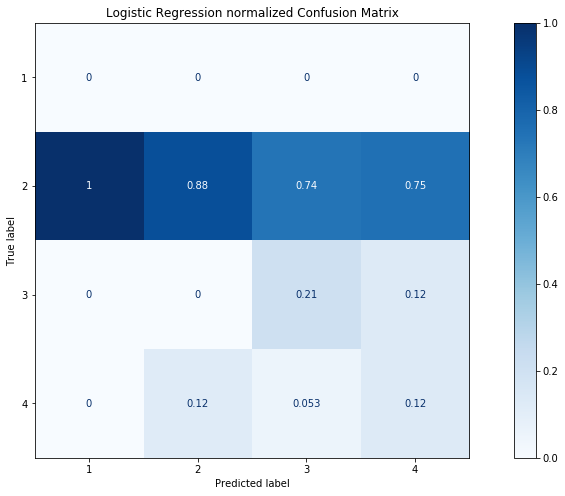

In [47]:
eval_cm(LogisticRegression, tf_covariates, mod_train, mod_test)

Insights
The confusion matriz shows:

Predictions of class 1 are not correct. They are actually all class 2.
88% predictions of class 2 are correct, the incorrect 12% are actually class 4.
21% predictions of class 3 are correct. 74% and about 5% of incorrect class 3 predictions are actually class 2 and class 4, respectively.
12% predictions of class 4 are correct. 75% and 12% of incorrect class 4 predictions are actually class 2 and class 3, respectively.
A couple of engineered features can improve a lot our Logistic Regression Classifier, with a F1 score of 0.61.

#### Better data wins !!!

In [48]:
# Logistic Regression - Model 1.3
all_covariates = ["x_mean", "y_mean", "z_mean", "x_sd", "y_sd", "z_sd", "m_mean", "m_sd", "x_E", "y_E", "z_E"]
mod3_best, mod3_preds, mod3_F1  = predict_F1(LogisticRegression, all_covariates, mod_train, mod_test)

mod3 = pd.DataFrame({"Model":["LR with all features"], "F1_score":[mod3_F1], 
                     "EdX accuracy":[edx_scoring(mod3_preds, mod_test_labels)]})
results = pd.concat([results, np.round(mod3, 5)], sort = "False", ignore_index = True)
print(results)

  EdX accuracy F1_score                                Model
0       0.1489  0.15933          LR with x, y, z raw signals
1       0.5426  0.60929  LR with means and energies features
2       0.5638  0.62604                 LR with all features


F1 score: 0.6260422860158751
classes counts: 
[[ 2  3  4]
 [50 27 17]]


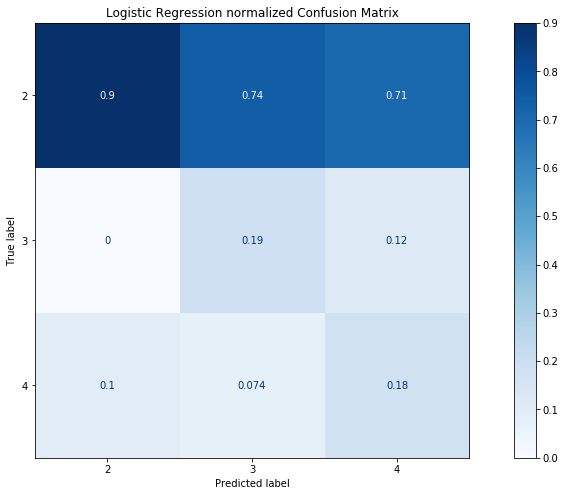

In [49]:
eval_cm(LogisticRegression, all_covariates, mod_train, mod_test)

#### K-nearest neighbour classifier

In [50]:
# k-Nearest Neighbors - Model 2.1
raw_covariates = ["x", "y", "z"] 
mod4_best, mod4_preds, mod4_F1  = predict_F1(KNeighborsClassifier, raw_covariates, mod_train, mod_test)

mod4 = pd.DataFrame({"Model":["k-NN with x, y, z raw signals"], "F1_score":[mod4_F1], 
                     "EdX accuracy":[edx_scoring(mod4_preds, mod_test_labels)]})
results = pd.concat([results, np.round(mod4, 5)], sort = "False", ignore_index = True)
print(results)

  EdX accuracy F1_score                                Model
0       0.1489  0.15933          LR with x, y, z raw signals
1       0.5426  0.60929  LR with means and energies features
2       0.5638  0.62604                 LR with all features
3       0.4894  0.56062        k-NN with x, y, z raw signals


F1 score: 0.5606161347517731
classes counts: 
[[ 1  2  3  4]
 [ 4 51 29 10]]


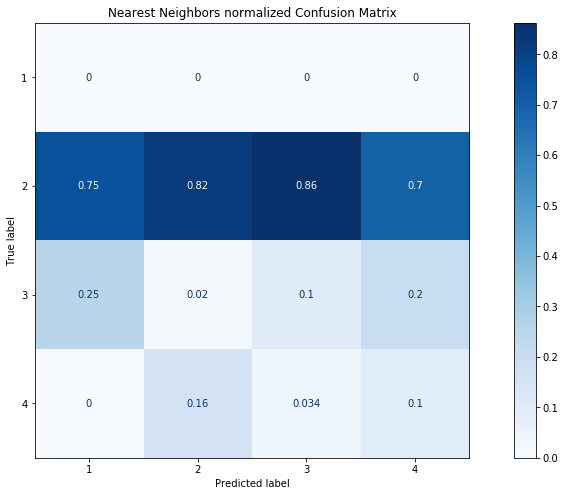

In [51]:
eval_cm(KNeighborsClassifier, raw_covariates, mod_train, mod_test)

Insights
The confusion matrix shows:

Prediction of class 1 is not correct.
82% predictions of class 2 are correct.
10% predictions of class 3 are correct.
10% predictions of class 4 are correct.
This first Nearest Neighbors Classifier model, with raw data, yields a F1 score of 0.56, which is:

Better than the first Logistic Regression Classifier model, with raw data (F1 score of 0.16),
But not as good as the second Logistic Regression Classifier model, with engineered features (F1 score of 0.61).
So in this case, Nearest Neighbors is clever than Logistic Regression, but better data beats clever algorithm.

In [52]:
# k-Nearest Neighbors - Model 2.2
tf_covariates = ["x_mean", "y_mean", "z_mean", "x_E", "y_E", "z_E"] 
mod5_best, mod5_preds, mod5_F1  = predict_F1(KNeighborsClassifier, tf_covariates, mod_train, mod_test)

mod5 = pd.DataFrame({"Model":["k-NN with means and energies features"], "F1_score":[mod5_F1], 
                     "EdX accuracy":[edx_scoring(mod5_preds, mod_test_labels)]})
results = pd.concat([results, np.round(mod5, 5)], sort = "False", ignore_index = True)
print(results)

  EdX accuracy F1_score                                  Model
0       0.1489  0.15933            LR with x, y, z raw signals
1       0.5426  0.60929    LR with means and energies features
2       0.5638  0.62604                   LR with all features
3       0.4894  0.56062          k-NN with x, y, z raw signals
4       0.5851  0.63107  k-NN with means and energies features


F1 score: 0.6310692953924008
classes counts: 
[[ 2  3  4]
 [61 24  9]]


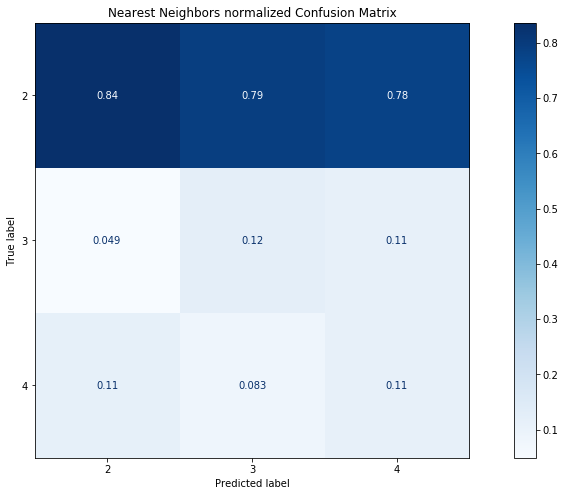

In [53]:
eval_cm(KNeighborsClassifier, tf_covariates, mod_train, mod_test)

Insights
The confusion matriz shows:

84% predictions of class 2 are correct.
12% predictions of class 3 are correct.
11% predictions of class 4 are correct.
Improvement of F1 score from 0.56 to 0.63. Yes, better data wins!

In [54]:
# k-Nearest Neighbors - Model 2.3
all_covariates = ["x_mean", "y_mean", "z_mean", "x_sd", "y_sd", "z_sd", "m_mean", "m_sd", "x_E", "y_E", "z_E"]
mod6_best, mod6_preds, mod6_F1  = predict_F1(KNeighborsClassifier, all_covariates, mod_train, mod_test)

mod6 = pd.DataFrame({"Model":["k-NN with all features"], "F1_score":[mod6_F1], 
                     "EdX accuracy":[edx_scoring(mod6_preds, mod_test_labels)]})
results = pd.concat([results, np.round(mod6, 5)], sort = "False", ignore_index = True)
print(results)

  EdX accuracy F1_score                                  Model
0       0.1489  0.15933            LR with x, y, z raw signals
1       0.5426  0.60929    LR with means and energies features
2       0.5638  0.62604                   LR with all features
3       0.4894  0.56062          k-NN with x, y, z raw signals
4       0.5851  0.63107  k-NN with means and energies features
5       0.6702  0.69873                 k-NN with all features


F1 score: 0.6987331029884223
classes counts: 
[[ 2  3  4]
 [66 20  8]]


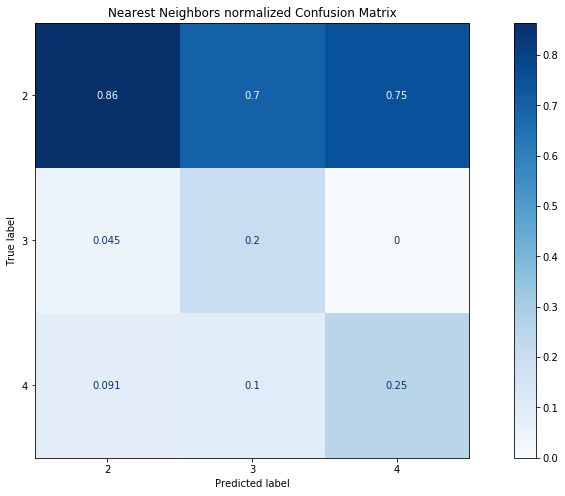

In [55]:
eval_cm(KNeighborsClassifier, all_covariates, mod_train, mod_test)

Insights
The confusion matriz shows:

86% predictions of class 2 are correct.
20% predictions of class 3 are correct.
25% predictions of class 4 are correct.
Improvement of F1 score from 0.63 to 0.70, which may be considered as good.

### Random forests classifier

In [56]:
# Random Forest - Model 3.1
raw_covariates = ["x", "y", "z"] 
mod7_best, mod7_preds, mod7_F1  = predict_F1(RandomForestClassifier, raw_covariates, mod_train, mod_test)

mod7 = pd.DataFrame({"Model":["RF with x, y, z raw signals"], "F1_score":[mod7_F1], 
                     "EdX accuracy":[edx_scoring(mod7_preds, mod_test_labels)]})
results = pd.concat([results, np.round(mod7, 5)], sort = "False", ignore_index = True)
print(results)

  EdX accuracy F1_score                                  Model
0       0.1489  0.15933            LR with x, y, z raw signals
1       0.5426  0.60929    LR with means and energies features
2       0.5638  0.62604                   LR with all features
3       0.4894  0.56062          k-NN with x, y, z raw signals
4       0.5851  0.63107  k-NN with means and energies features
5       0.6702  0.69873                 k-NN with all features
6       0.4787  0.56027            RF with x, y, z raw signals


F1 score: 0.5602658730605218
classes counts: 
[[ 1  2  3  4]
 [ 7 45 21 21]]


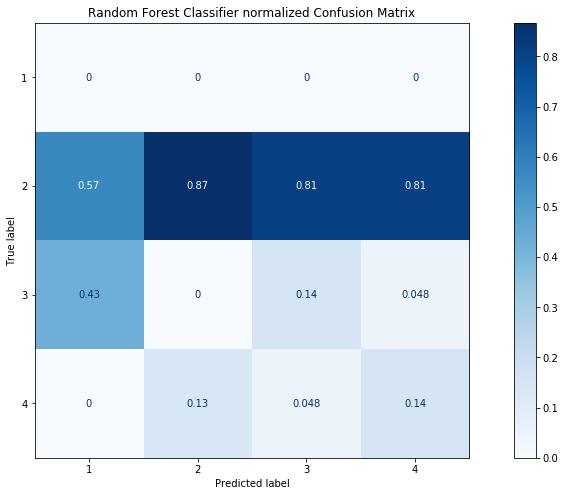

In [57]:
eval_cm(RandomForestClassifier, raw_covariates, mod_train, mod_test)

Insights
The confusion matrix shows:

Prediction of class 1 is not correct.
87% predictions of class 2 are correct.
14% predictions of class 3 are correct.
14% predictions of class 4 are correct.
This first Random Forest Classifier model, with raw data, gives slightly better predictions than our first model of Nearest Neighbors Classifier.

In [58]:
# Random Forest - Model 3.2
tf_covariates = ["x_mean", "y_mean", "z_mean", "x_E", "y_E", "z_E"] 
mod8_best, mod8_preds, mod8_F1  = predict_F1(RandomForestClassifier, tf_covariates, mod_train, mod_test)

mod8 = pd.DataFrame({"Model":["RF with means and energies features"], "F1_score":[mod8_F1], 
                     "EdX accuracy":[edx_scoring(mod8_preds, mod_test_labels)]})
results = pd.concat([results, np.round(mod8, 5)], sort = "False", ignore_index = True)
print(results)

  EdX accuracy F1_score                                  Model
0       0.1489  0.15933            LR with x, y, z raw signals
1       0.5426  0.60929    LR with means and energies features
2       0.5638  0.62604                   LR with all features
3       0.4894  0.56062          k-NN with x, y, z raw signals
4       0.5851  0.63107  k-NN with means and energies features
5       0.6702  0.69873                 k-NN with all features
6       0.4787  0.56027            RF with x, y, z raw signals
7       0.6809  0.70498    RF with means and energies features


F1 score: 0.7049828055879853
classes counts: 
[[ 2  3  4]
 [64 21  9]]


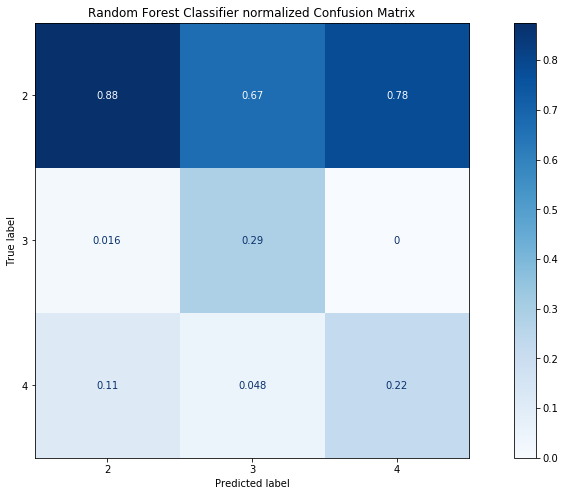

In [59]:
eval_cm(RandomForestClassifier, tf_covariates, mod_train, mod_test)

Insights
The confusion matrix shows

88% predictions of class 2 are correct.
29% predictions of class 3 are correct.
22% predictions of class 4 are correct.
Better predictions than Nearest Neighbors in the same setup and F1 score of 0.70 versus 0.63.

In [60]:
# Random Forest - Model 3.3
all_covariates = ["x_mean", "y_mean", "z_mean", "x_sd", "y_sd", "z_sd", "m_mean", "m_sd", "x_E", "y_E", "z_E"] 
mod9_best, mod9_preds, mod9_F1  = predict_F1(RandomForestClassifier, all_covariates, mod_train, mod_test)

mod9 = pd.DataFrame({"Model":["RF with all features"], "F1_score":[mod9_F1], 
                     "EdX accuracy":[edx_scoring(mod9_preds, mod_test_labels)]})
results = pd.concat([results, np.round(mod9, 5)], sort = "False", ignore_index = True)
print(results)

  EdX accuracy F1_score                                  Model
0       0.1489  0.15933            LR with x, y, z raw signals
1       0.5426  0.60929    LR with means and energies features
2       0.5638  0.62604                   LR with all features
3       0.4894  0.56062          k-NN with x, y, z raw signals
4       0.5851  0.63107  k-NN with means and energies features
5       0.6702  0.69873                 k-NN with all features
6       0.4787  0.56027            RF with x, y, z raw signals
7       0.6809  0.70498    RF with means and energies features
8       0.6702  0.70182                   RF with all features


F1 score: 0.7018164634286902
classes counts: 
[[ 2  3  4]
 [65 19 10]]


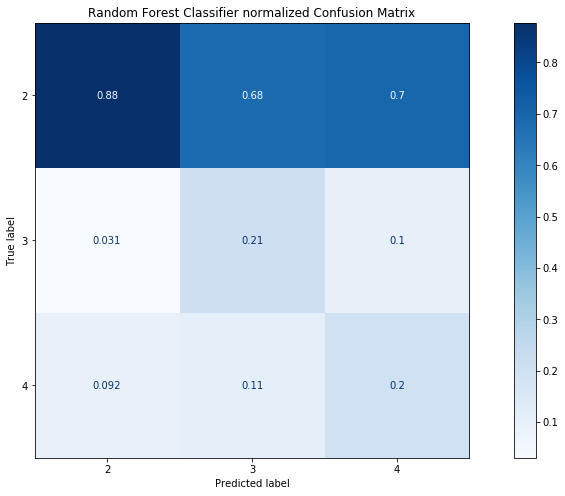

In [61]:
eval_cm(RandomForestClassifier, all_covariates, mod_train, mod_test)

Insights
The confusion matrix shows

88% predictions of class 2 are correct.
21% predictions of class 3 are correct.
20% predictions of class 4 are correct.
F1 score of 0.70, same as for Nearest Neighbors.

### Gradient Boosting Classifier

In [62]:
# Gradient Boosting - Model 4.1
raw_covariates = ["x", "y", "z"]
mod10_best, mod10_preds, mod10_F1  = predict_F1(GradientBoostingClassifier, raw_covariates, mod_train, mod_test)

mod10 = pd.DataFrame({"Model":["GB with x, y, z raw signals"], "F1_score":[mod10_F1], 
                     "EdX accuracy":[edx_scoring(mod10_preds, mod_test_labels)]})
results = pd.concat([results, np.round(mod10, 5)], sort = "False", ignore_index = True)
print(results)

  EdX accuracy F1_score                                  Model
0       0.1489  0.15933            LR with x, y, z raw signals
1       0.5426  0.60929    LR with means and energies features
2       0.5638  0.62604                   LR with all features
3       0.4894  0.56062          k-NN with x, y, z raw signals
4       0.5851  0.63107  k-NN with means and energies features
5       0.6702  0.69873                 k-NN with all features
6       0.4787  0.56027            RF with x, y, z raw signals
7       0.6809  0.70498    RF with means and energies features
8       0.6702  0.70182                   RF with all features
9       0.5851  0.62574            GB with x, y, z raw signals


F1 score: 0.6257431718726423
classes counts: 
[[ 1  2  3  4]
 [ 2 64 23  5]]


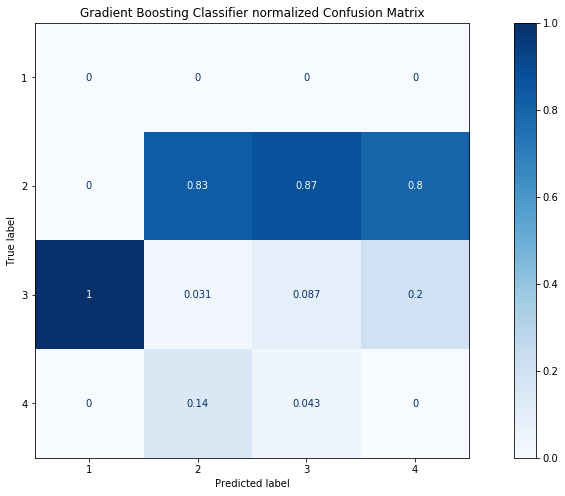

In [63]:
eval_cm(GradientBoostingClassifier, raw_covariates, mod_train, mod_test)

Insights
The confusion matrix shows Prediction of class 1 is not correct.

83% predictions of class 2 are correct.
About 9% predictions of class 3 are correct.
No correct predictions of class 4.
This first Gradient Boosting Classifier model, with raw data, yields a better F1 score than our first model of Random Forest Classifier, 0.63 vs. 0.56, but predictions of classes 3 and 4 are not as good.

In [64]:
# Gradient Boosting - Model 4.2
tf_covariates = ["x_mean", "y_mean", "z_mean", "x_E", "y_E", "z_E"] 
mod11_best, mod11_preds, mod11_F1  = predict_F1(GradientBoostingClassifier, tf_covariates, mod_train, mod_test)

mod11 = pd.DataFrame({"Model":["GB with means and energies features"], "F1_score":[mod11_F1], 
                     "EdX accuracy":[edx_scoring(mod11_preds, mod_test_labels)]})
results = pd.concat([results, np.round(mod11, 5)], sort = "False", ignore_index = True)
print(results)

   EdX accuracy F1_score                                  Model
0        0.1489  0.15933            LR with x, y, z raw signals
1        0.5426  0.60929    LR with means and energies features
2        0.5638  0.62604                   LR with all features
3        0.4894  0.56062          k-NN with x, y, z raw signals
4        0.5851  0.63107  k-NN with means and energies features
5        0.6702  0.69873                 k-NN with all features
6        0.4787  0.56027            RF with x, y, z raw signals
7        0.6809  0.70498    RF with means and energies features
8        0.6702  0.70182                   RF with all features
9        0.5851  0.62574            GB with x, y, z raw signals
10       0.6489  0.66609    GB with means and energies features


F1 score: 0.666085160729328
classes counts: 
[[ 2  3  4]
 [68 20  6]]


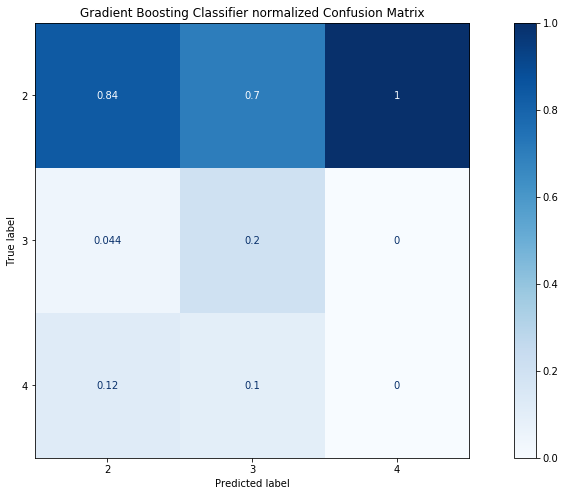

In [65]:
eval_cm(GradientBoostingClassifier, tf_covariates, mod_train, mod_test)

Insights
The confusion matrix shows

84% predictions of class 2 are correct.
20% predictions of class 3 are correct.
No predictions of class 4 are correct.
The F1 score of 0.67 is the same as for Random Forest but here again predictions are not as good.

In [66]:
# Gradient Boosting - Model 4.3
all_covariates = ["x_mean", "y_mean", "z_mean", "x_sd", "y_sd", "z_sd", "m_mean", "m_sd", "x_E", "y_E", "z_E"] 
mod12_best, mod12_preds, mod12_F1  = predict_F1(GradientBoostingClassifier, all_covariates, mod_train, mod_test)

mod12 = pd.DataFrame({"Model":["GB with all features"], "F1_score":[mod12_F1], 
                     "EdX accuracy":[edx_scoring(mod12_preds, mod_test_labels)]})
results = pd.concat([results, np.round(mod12, 5)], sort = "False", ignore_index = True)
print(results)

   EdX accuracy F1_score                                  Model
0        0.1489  0.15933            LR with x, y, z raw signals
1        0.5426  0.60929    LR with means and energies features
2        0.5638  0.62604                   LR with all features
3        0.4894  0.56062          k-NN with x, y, z raw signals
4        0.5851  0.63107  k-NN with means and energies features
5        0.6702  0.69873                 k-NN with all features
6        0.4787  0.56027            RF with x, y, z raw signals
7        0.6809  0.70498    RF with means and energies features
8        0.6702  0.70182                   RF with all features
9        0.5851  0.62574            GB with x, y, z raw signals
10       0.6489  0.66609    GB with means and energies features
11       0.7128  0.71572                   GB with all features


F1 score: 0.7157207350695856
classes counts: 
[[ 2  3  4]
 [72 19  3]]


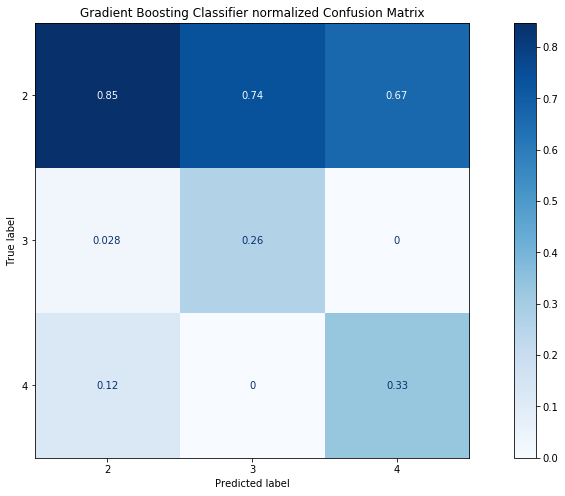

In [67]:
eval_cm(GradientBoostingClassifier, all_covariates, mod_train, mod_test)

Insights
The confusion matrix shows:

85% predictions of class 2 are correct.
26% predictions of class 3 are correct.
33% predictions of class 4 are correct.
F1 score of about 0.72, slightly better than Random Forest.

So, F1 scores between Random Forest and Gradient Boosting are similar but Random Forest seems more robust with a higher F1 score median. We may select the third Random Forest model.

We may also note here that our best F1 score is a bit behind our baseline F1 score (remember our "informed guess" model) of 0.74, but of course, false positive rates are better with our classifiers, so we don't miss any of the minority classes.

#### Validation

So let's summarize here our best model as a Random Forest Classifier with all the features that we have defined in section 4.4 Feature Engineering, i.e.:

Averages of signals x, y, and z; x_mean, y_mean, z_mean
Standard deviations of signals x, y, and z; x_sd, y_sd, z_sd
Averages of x-y-z magnitude; m_mean
Standard deviations of x-y-z magnitude; m_sd
Energies of signals x, y, and z; x_E, y_E, z_E

In [68]:
print("The estimator was defined as: \n%s" % mod9_best)

The estimator was defined as: 
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=699,
                       verbose=0, warm_start=False)


In [69]:
print("Predictions: \n%s" % list(mod9_preds))

Predictions: 
[2, 2, 4, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 4, 2, 2, 2, 3, 2, 4, 2, 2, 2, 2, 2, 2, 2, 3, 4, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 4, 2, 3, 4, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 4, 4]


In [70]:
print("The F1 score for this model is %f" % mod9_F1)
print("The EdX accuracy for this model is %.2f%%" % np.round(edx_scoring(mod9_preds, mod_test_labels)*100.00, 5))

The F1 score for this model is 0.701816
The EdX accuracy for this model is 67.02%


Now let's proceed with the validation on the initial test time series set that we have defined as X_test in the beginning.

In [71]:
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (374, 17)
X_test shape:  (125, 17)


In [72]:
covariates = ["x_mean", "y_mean", "z_mean", "x_sd", "y_sd", "z_sd", "m_mean", "m_sd", "x_E", "y_E", "z_E"] 
train_covariates = X_train[covariates]
train_labels = X_train["label"].astype("int")
test_covariates = X_test[covariates]

tscv = TimeSeriesSplit(n_splits = 5) 

rfc = RandomForestClassifier(class_weight = "balanced", random_state = 699) # class_weight = "balanced" for unbalanced datasets
param_grid = {"n_estimators": [10, 20, 60, 100], "criterion": ["gini", "entropy"], "max_depth": [6, 8, 12, 16]}
rfc_grid = GridSearchCV(rfc, param_grid, scoring = "f1_weighted", cv = tscv)
rfc_grid.fit(train_covariates, train_labels);
best_rfc = rfc_grid.best_estimator_
rfc_predictions = best_rfc.fit(train_covariates, train_labels).predict(test_covariates)

In [73]:
print("Predictions: \n%s" % list(rfc_predictions))

Predictions: 
[2, 2, 3, 2, 4, 2, 4, 4, 4, 3, 3, 4, 2, 2, 4, 4, 2, 4, 4, 4, 2, 3, 2, 2, 4, 3, 2, 2, 2, 2, 4, 2, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 3, 4, 3, 3, 3, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 2, 2, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2]


In [74]:
# save to csv file
savetxt('predictions.csv', rfc_predictions, delimiter = ",")

We can visualize these predictions along x, y, and z signals to have an idea of their distribution.

In [75]:
X_test["predictions"] = rfc_predictions

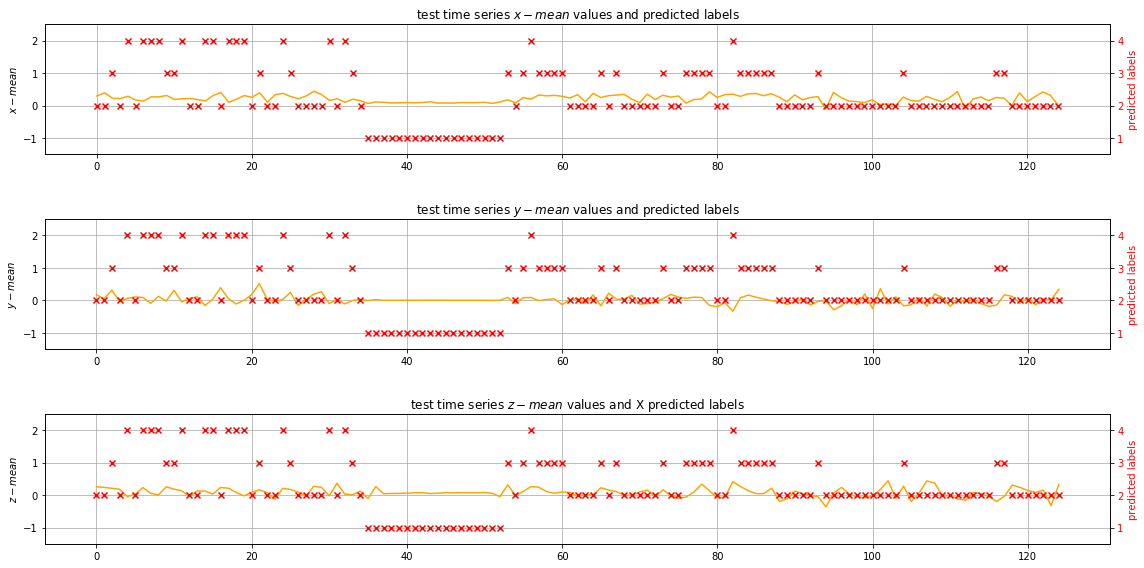

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(X_test["x_mean"], color = "orange")
ax1.grid(True)
ax1.set_ylim((-1.5, 2.5))
ax1.set_ylabel("$x-mean$")
ax1.set_title("test time series $x-mean$ values and predicted labels")

ax11 = ax1.twinx()  
ax11.set_ylim((0.5, 4.5))
ax11.set_ylabel("predicted labels", color = "red")
ax11.scatter(x = X_test.index, y = X_test["predictions"], color = "red", marker = "x")
ax11.tick_params(axis = "y", labelcolor = "red")
fig.tight_layout()  

ax2.plot(X_test["y_mean"], color = "orange")
ax2.grid(True)
ax2.set_ylim((-1.5, 2.5))
ax2.set_ylabel("$y-mean$")
ax2.set_title("test time series $y-mean$ values and predicted labels")

ax21 = ax2.twinx() 
ax21.set_ylim((0.5, 4.5))
ax21.set_ylabel("predicted labels", color = "red")
ax21.scatter(x = X_test.index, y = X_test["predictions"], color = "red", marker = "x")
ax21.tick_params(axis = "y", labelcolor = "red")
fig.tight_layout()  

ax3.plot(X_test["z_mean"], color = "orange")
ax3.grid(True)
ax3.set_ylim((-1.5, 2.5))
ax3.set_ylabel("$z-mean$")
ax3.set_title("test time series $z-mean$ values and X predicted labels")

ax31 = ax3.twinx()  
ax31.set_ylim((0.5, 4.5))
ax31.set_ylabel("predicted labels", color = "red")
ax31.scatter(x = X_test.index, y = X_test["predictions"], color = "red", marker = "x")
ax31.tick_params(axis = "y", labelcolor = "red")
fig.tight_layout()  

plt.subplots_adjust(hspace = 0.5)

Insights
Class 1 looks good.
Classes 2, 3 and 4
Class 2 looks just fine. It has the biggest count, still our majority class, which could also make sense in our time series.
It's difficult to say for predictions of class 3 and class 4. Our model is quite confusing the upstairs and downstairs activities. That’s also somewhat expected.
However, it's not realistic to have these jumps of class among walking, stairs down and stairs up. Remember a label is recorded every second.

#### Additional system information for reference.

In [77]:
import platform
import psutil

In [78]:
# System Information
print("="*40, "System Information", "="*40)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")
print(f"Processor: {uname.processor}")

# CPU Information
print("="*40, "CPU Info", "="*50)
# number of cores
print("Physical cores:", psutil.cpu_count(logical=False))
print("Total cores:", psutil.cpu_count(logical=True))
# CPU frequencies
cpufreq = psutil.cpu_freq()
print(f"Max Frequency: {cpufreq.max:.2f}Mhz")
print(f"Min Frequency: {cpufreq.min:.2f}Mhz")
print(f"Current Frequency: {cpufreq.current:.2f}Mhz")
# CPU usage
print("CPU Usage Per Core:")
for i, percentage in enumerate(psutil.cpu_percent(percpu=True)):
    print(f"Core {i}: {percentage}%")
print(f"Total CPU Usage: {psutil.cpu_percent()}%")

# Function that converts large number of bytes into a scaled format (e.g in kilo, mega, giga, etc.)
def get_size(bytes, suffix="B"):
    """
    Scale bytes to its proper format
    e.g:
        1253656 => '1.20MB'
        1253656678 => '1.17GB'
    """
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor

# Memory Information
print("="*40, "Memory Information", "="*40)
# get the memory details
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}")
print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}")
print(f"Percentage: {svmem.percent}%")
print("="*20, "SWAP", "="*20)
# get the swap memory details (if exists)
swap = psutil.swap_memory()
print(f"Total: {get_size(swap.total)}")
print(f"Free: {get_size(swap.free)}")
print(f"Used: {get_size(swap.used)}")
print(f"Percentage: {swap.percent}%")

# Environment information
print("="*40, "Environment Information", "="*35)
print("Notebook version: JupyterLab, version 1.2.4")
print("Python version:", platform.python_version())
print("Scikit-learn version:", sklearn.__version__)
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)

======================================== System Information ========================================
System: Windows
Release: 10
Version: 10.0.18362
Machine: AMD64
Processor: Intel64 Family 6 Model 61 Stepping 4, GenuineIntel
======================================== CPU Info ==================================================
Physical cores: 2
Total cores: 4
Max Frequency: 1997.00Mhz
Min Frequency: 0.00Mhz
Current Frequency: 499.00Mhz
CPU Usage Per Core:
Core 0: 52.8%
Core 1: 51.8%
Core 2: 62.0%
Core 3: 72.7%
Total CPU Usage: 59.8%
======================================== Memory Information ========================================
Total: 7.90GB
Available: 3.28GB
Used: 4.62GB
Percentage: 58.4%
==================== SWAP ====================
Total: 15.88GB
Free: 6.30GB
Used: 9.58GB
Percentage: 60.3%
======================================== Environment Information ===================================
Notebook version: JupyterLab, version 1.2.4
Python version: 3.7.6
Scikit-learn version: 0.22

In [79]:
print("The estimator was defined as: \n%s" % mod9_best)

The estimator was defined as: 
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=699,
                       verbose=0, warm_start=False)


## Conclusion

We started with an Exploratory Data Analysis, which provided some insights such as:

train time series and test time series come from one same time series of about 8 minutes, which was split at 75/25 for the purpose of this project.
Sampling of x, y, z acceleration signals at 10 Hz (10 samples per second) and class/activity labelling every second.

A clear imbalance among our labels/classes:

Class 1 (standing): 26 counts
Class 2 (walking): 213 counts
Class 3 (stairs down): 88 counts
Class 4 (stairs up): 47 counts
An impression of actual lag between the x, y, z acceleration signals and some transitions of classes/activities. Further information about activity labelling could help to explain these observations.

Then we proceeded with Feature Engineering, where we brought in some signal domain knowledge to define a few additional features:

Rolling averages for:

acceleration signals x, y, z,
magnitude (x, y, z combined)
Rolling standards deviations for:

acceleration signals x, y, z,
magnitude
Energies of signals x, y, z.

The rolling time window is of 5 observations, i.e. 0.5 sec. As we aggregated only over 5 observations, data leakage is very limited and may be considered as not significant.

Finally, we tested four Machine Learning classifiers from the scikit-learn package to build the best model as possible.

Logistic Regression
k-Nearest Neighbors
Random Forest
Gradient Boosting
Although the Gradient Boosting Classifier with all engineered features model yields better numbers, we chose the Random Forest Classifier as it seems to be more robust by observing the results over all setups.

Validation of our model shows a good classification of class 1 (walking) but mixed results for classes 2, 3 and 4. That's somewhat expected as we their related activities (respectively waling, stairs down and stairs up) are similar in nature.

We probably could improve our predictions if:

We had more data for training, for example data from various accelerometers, and/or from various individuals testing the sensors, and/or from different sensors such as the smartphone gyroscope. We could also have a longer time series * covering more of the stairs up and stairs down to balance the classes.
We could use some smart signal processing such as filtering.
We could use clever algorithm for activity classification such as Movelet
Having that said, let's keep in mind this fine quote from Peter Norvig, Director of Research at Google:

"More data beats clever algorithms but better data beats more data."
Thank you for reading the report.